In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import img_as_float
from scipy.ndimage import convolve
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte  
from skimage.restoration import denoise_tv_chambolle


In [2]:
def gaussian_noise(image, mean=0, sigma=0.1):
    normal_noise = np.random.normal(mean, sigma, image.shape)
    image = img_as_float(image)
    
    noisy_img = image + normal_noise
    noisy_img = np.clip(noisy_img, 0., 1.0)
    noisy_img = np.uint8(noisy_img*255)
    
    return noisy_img

In [3]:
def gaussian_kernel_nlm(range, sigma):
    range_vals = np.arange(-range, range + 1)
    x, y = np.meshgrid(range_vals, range_vals)
    gaussian_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    # Normalizing gaussian kernel
    gaussian_kernel /= np.sum(gaussian_kernel)
    return gaussian_kernel

<h1>Non local means function</h1>

In [4]:
def non_local_means(noisy_image, big_window_size, small_window_size, h, a):
    pad_width = big_window_size // 2
    image = noisy_image.copy()

    padded_image = np.pad(image, ((pad_width, pad_width), (pad_width, pad_width)), mode='reflect')

    # Type cast data to uint8 type
    padded_image = padded_image.astype(np.uint8)

    output_image = padded_image.copy()

    small_half_width = small_window_size // 2

    kernel = gaussian_kernel_nlm(small_half_width, a)

    # For each pixel in noisy image, find the neighbourhood window that will be compared
    for image_x in range(pad_width, pad_width + image.shape[1]):
        for image_y in range(pad_width, pad_width + image.shape[0]):

            b_win_x = image_x - pad_width
            b_win_y = image_y - pad_width

            # Extracting comparison neighborhood 
            center_nb = padded_image[image_y - small_half_width:image_y + small_half_width + 1,
                        image_x - small_half_width:image_x + small_half_width + 1]

            new_intensity = 0.0
            normalization_factor = 0.0

            # For each comparison neighborhood, compute the weights with all small windows within the large window
            for s_win_x in range(b_win_x, b_win_x + big_window_size - small_window_size + 1):
                for s_win_y in range(b_win_y, b_win_y + big_window_size - small_window_size + 1):
                    if (s_win_x, s_win_y) != (image_x, image_y):
                        # sliding small neighborhood throughout the large window
                        small_nb = padded_image[s_win_y:s_win_y + (small_half_width * 2) + 1,
                                     s_win_x:s_win_x + (small_half_width * 2) + 1]

                        # Compute the weight for the small window
                        weight = np.exp(
                            -np.sum(kernel * np.square(center_nb.astype(np.float32) - small_nb.astype(np.float32))) / (h ** 2))

                        # Sum the weighted intensities
                        new_intensity += weight * padded_image[s_win_y + small_half_width, s_win_x + small_half_width]
                        normalization_factor += weight

            # Update the output image
            output_image[image_y, image_x] = np.round(new_intensity / normalization_factor).astype(np.uint8)

    return output_image[pad_width:-pad_width, pad_width:-pad_width]


<h1>Gaussian Filter</h1>

In [5]:
def gaussian_filter(image, kernel_size=3, sigma=1):
    padded_image = np.pad(image, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2)), mode='constant')
    kernel = gaussian_kernel(kernel_size, sigma)
    result = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size] * kernel)

    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

<h1>Median Filter</h1>

In [6]:
def median_filter(image, kernel_size=3):
    padded_image = np.pad(image, ((kernel_size // 2, kernel_size // 2), (kernel_size // 2, kernel_size // 2)), mode='constant')
    result = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size])

    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

<h1>Moving Average Filter</h1>

In [7]:
def moving_average_filter(image, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size * kernel_size)
    result = cv2.filter2D(image, -1, kernel)
    return result

<h1> Tabulating PSNRs, SSIMs for denoised results </h1>

In [8]:
from tabulate import tabulate

def compare(image, sigma,h,a, zoom=True):
    original_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    #original_image = original_image#[200:500, 200:500]  # Crop or resize as needed

    noisy_image = gaussian_noise(original_image, sigma=sigma)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

    show_orig = original_image
    show_noisy = noisy_image
    # Plot the original image
    if zoom==True:
        show_orig = original_image[200:400,200:400]
        show_noisy = noisy_image[200:400,200:400]
        
    axes[0].imshow(show_orig, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Plot the noisy image
    axes[1].imshow(show_noisy, cmap='gray')
    axes[1].set_title(f"Noisy image(σ={sigma})")
    axes[1].axis("off")
    
    #Get the denoised images
    denoised_NL = non_local_means(noisy_image, 11, 5, h,a=a) #h=32,a=5
    denoised_avg = moving_average_filter(noisy_image)
    denoised_median = median_filter(noisy_image)
    denoised_gaussian = gaussian_filter(noisy_image)
    denoised_tv = denoise_tv_chambolle(noisy_image, weight=0.04)

    # Calculate PSNR and SSIM for each denoised image
    methods = ['Moving Average filter', 'Median filter', 'Gaussian filter', 'TV Denoising', 'NL Means']
    psnr_values = []
    ssim_values = []

    for denoised_img in [denoised_avg, denoised_median, denoised_gaussian, denoised_tv, denoised_NL]:
        psnr = peak_signal_noise_ratio(img_as_ubyte(original_image), img_as_ubyte(denoised_img), data_range=255)
        ssim_val, _ = ssim(img_as_ubyte(original_image), img_as_ubyte(denoised_img), full=True)
        psnr_values.append(psnr)
        ssim_values.append(ssim_val)

    # Create a table
    table_data = {'Method': methods, 'PSNR': psnr_values, 'SSIM': ssim_values}
    table = tabulate(table_data, headers='keys', tablefmt='pretty')

    print(table)

    # Plot the denoised images
    fig1, axes1 = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
    k=0
    for ax, denoised_img, method in zip(axes1, [denoised_avg, denoised_median, denoised_gaussian, denoised_tv, denoised_NL], methods):
        show_denoised = denoised_img
        if zoom == True:
            show_denoised = denoised_img[200:400,200:400]
        ax.imshow(show_denoised, cmap='gray')
        ax.set_title(f"{method}\nPSNR: {psnr_values[k]:.2f}, SSIM: {ssim_values[k]:.2f}")
        ax.axis("off")
        k+=1

    plt.tight_layout()
    plt.show()

<h2>Denoising results performed on images with σ=0.1 Gaussian noise </h2>

+-----------------------+--------------------+--------------------+
|        Method         |        PSNR        |        SSIM        |
+-----------------------+--------------------+--------------------+
| Moving Average filter | 28.129378581790824 | 0.6466192189205014 |
|     Median filter     | 26.67514488345232  | 0.5712579453772713 |
|    Gaussian filter    | 27.624144302538586 | 0.6369581741270749 |
|     TV Denoising      | 26.575847532362488 | 0.5713673184056808 |
|       NL Means        | 30.177317143415443 | 0.7806663734710618 |
+-----------------------+--------------------+--------------------+


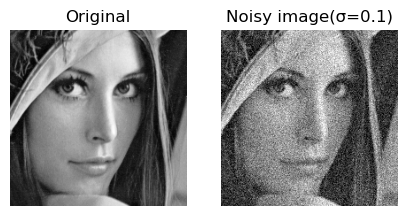

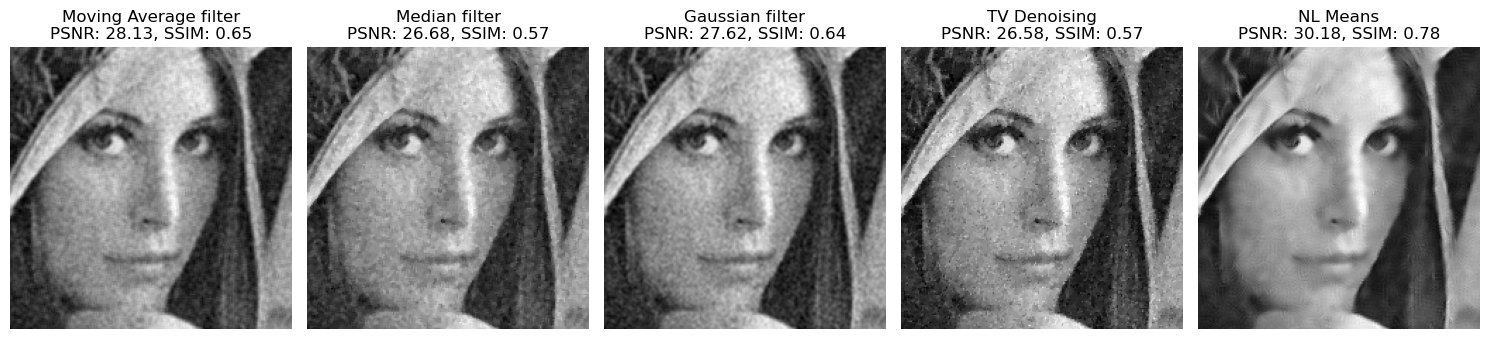

In [26]:
compare("lena512.bmp", sigma=0.1,h=32,a=5,zoom=True)

+-----------------------+--------------------+--------------------+
|        Method         |        PSNR        |        SSIM        |
+-----------------------+--------------------+--------------------+
| Moving Average filter | 24.37140183194739  | 0.5991925488541728 |
|     Median filter     | 24.14685514304127  | 0.5327987616799751 |
|    Gaussian filter    | 24.607343239254075 | 0.6073511637808006 |
|     TV Denoising      | 25.99631471390343  | 0.6004521073586123 |
|       NL Means        | 28.00194628064596  | 0.7614284344091385 |
+-----------------------+--------------------+--------------------+


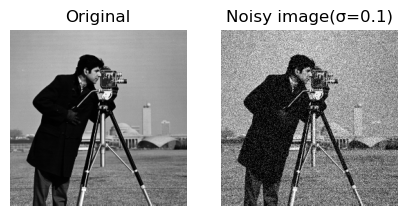

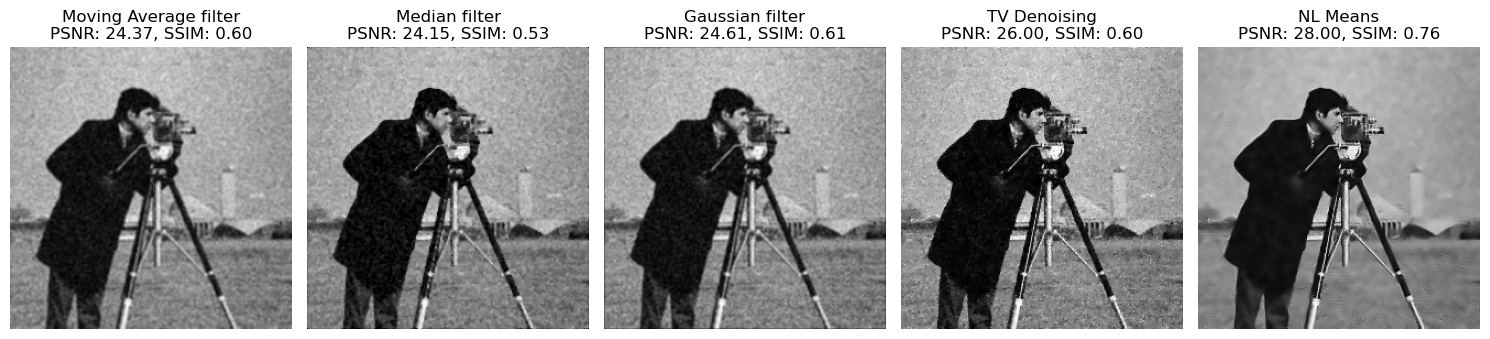

In [41]:
compare("Image3.png", sigma=0.1, h=32,a=5, zoom=False)

+-----------------------+--------------------+--------------------+
|        Method         |        PSNR        |        SSIM        |
+-----------------------+--------------------+--------------------+
| Moving Average filter | 27.185191476238714 | 0.6119583418557216 |
|     Median filter     | 26.262970056587292 | 0.5456489872562822 |
|    Gaussian filter    | 27.17025372077151  | 0.6025749720831957 |
|     TV Denoising      | 26.451072718376626 | 0.5450471762314736 |
|       NL Means        | 30.190912458038433 | 0.7842954064527576 |
+-----------------------+--------------------+--------------------+


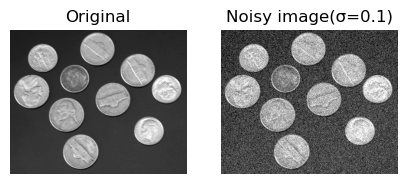

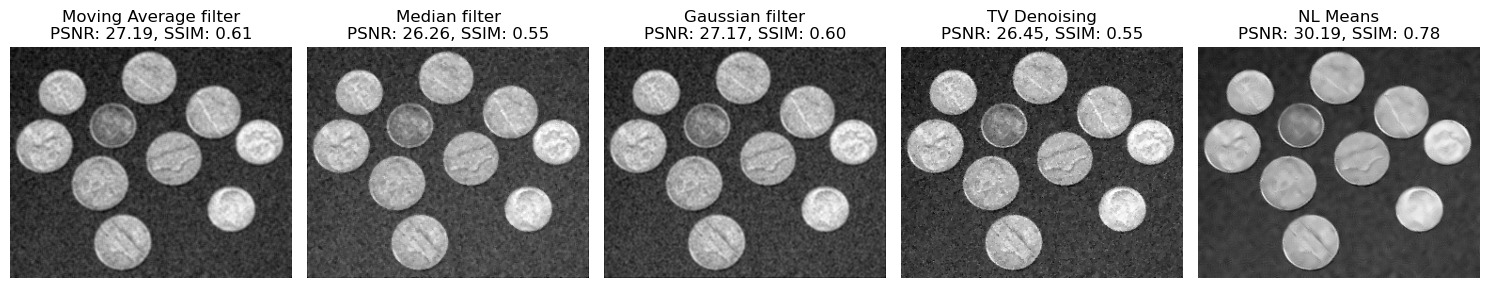

In [27]:
compare("Image4.png", sigma=0.1,h=32,a=5, zoom=False)

<h2>Denoising results performed on images with σ=0.2 Gaussian noise</h2>

+-----------------------+--------------------+---------------------+
|        Method         |        PSNR        |        SSIM         |
+-----------------------+--------------------+---------------------+
| Moving Average filter | 23.39196014302495  | 0.4111274958070397  |
|     Median filter     | 21.36931792308249  | 0.3290951457761028  |
|    Gaussian filter    | 22.906877618215553 |  0.397763598330747  |
|     TV Denoising      | 17.926236007142386 | 0.21433351725203129 |
|       NL Means        | 26.129927948607772 | 0.5878065473706681  |
+-----------------------+--------------------+---------------------+


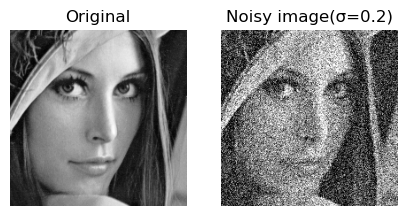

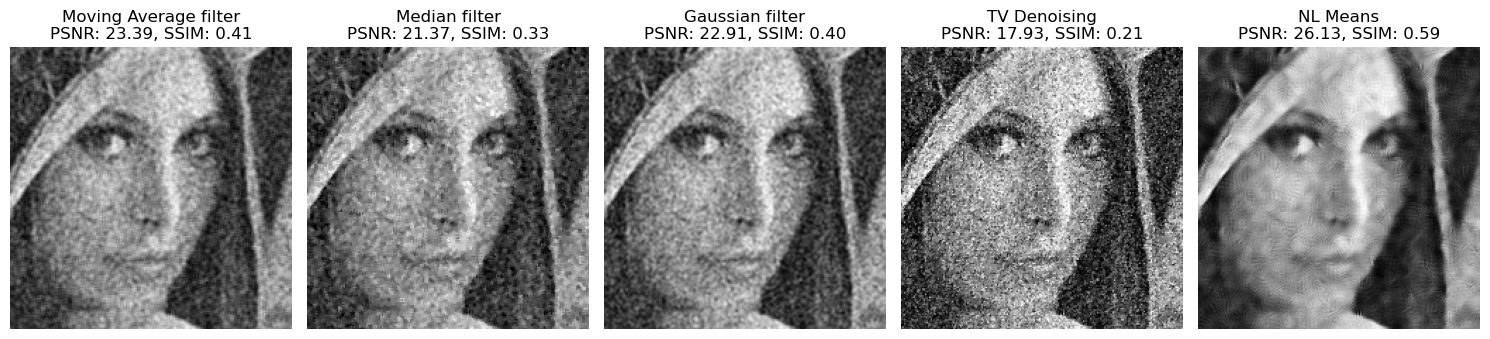

In [50]:
compare("lena512.bmp", sigma=0.2,h=60,a=5,zoom=True)  # h=55

+-----------------------+--------------------+--------------------+
|        Method         |        PSNR        |        SSIM        |
+-----------------------+--------------------+--------------------+
| Moving Average filter | 21.552958787768265 | 0.3937447547657181 |
|     Median filter     | 20.48094050413313  | 0.3400838075393425 |
|    Gaussian filter    | 21.475948607693766 | 0.3983729690346905 |
|     TV Denoising      |  18.0651139004829  | 0.2809190813059769 |
|       NL Means        | 23.37720943863885  | 0.5586671414878188 |
+-----------------------+--------------------+--------------------+


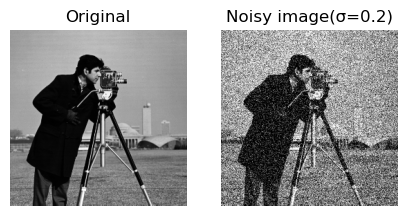

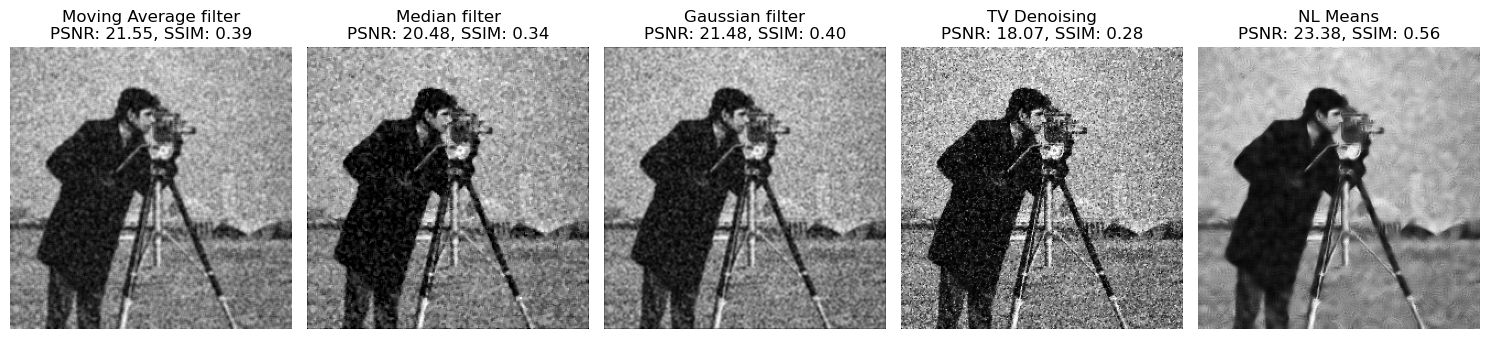

In [57]:
compare("Image3.png", sigma=0.2,h=60,a=5,zoom=False)  

+-----------------------+--------------------+---------------------+
|        Method         |        PSNR        |        SSIM         |
+-----------------------+--------------------+---------------------+
| Moving Average filter | 23.24573304521872  | 0.4008774391343255  |
|     Median filter     | 21.13535162065969  | 0.3210144627344057  |
|    Gaussian filter    | 22.99607408892095  | 0.39136980021007817 |
|     TV Denoising      | 18.28602537119699  | 0.23383509969201377 |
|       NL Means        | 25.849755226556535 | 0.5915087426215814  |
+-----------------------+--------------------+---------------------+


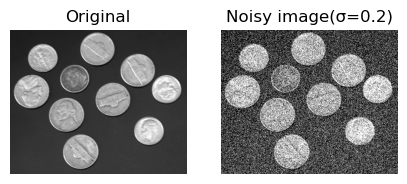

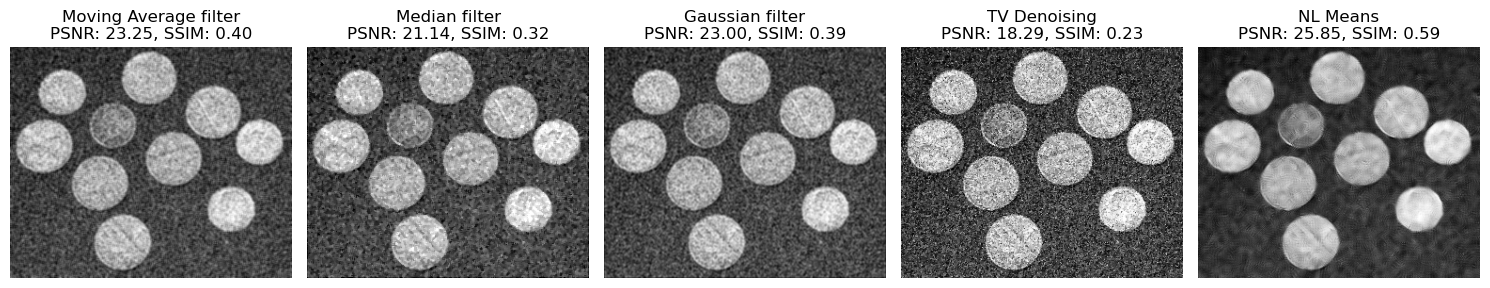

In [56]:
compare("Image4.png", sigma=0.2,h=60,a=5,zoom=False)  

<h2>Denoising results performed on images with σ=0.15 Gaussian noise</h2>

+-----------------------+--------------------+---------------------+
|        Method         |        PSNR        |        SSIM         |
+-----------------------+--------------------+---------------------+
| Moving Average filter | 25.497466033878347 | 0.5112038506575172  |
|     Median filter     | 23.698248957968325 | 0.42863038799201353 |
|    Gaussian filter    | 25.009235909720413 | 0.49860278810823677 |
|     TV Denoising      | 21.288266084161297 |  0.328740227560948  |
|       NL Means        | 27.164466145572966 | 0.6212196114009559  |
+-----------------------+--------------------+---------------------+


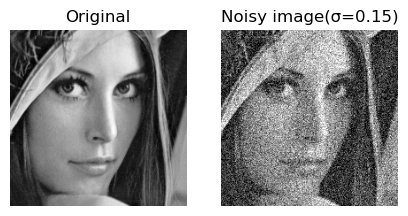

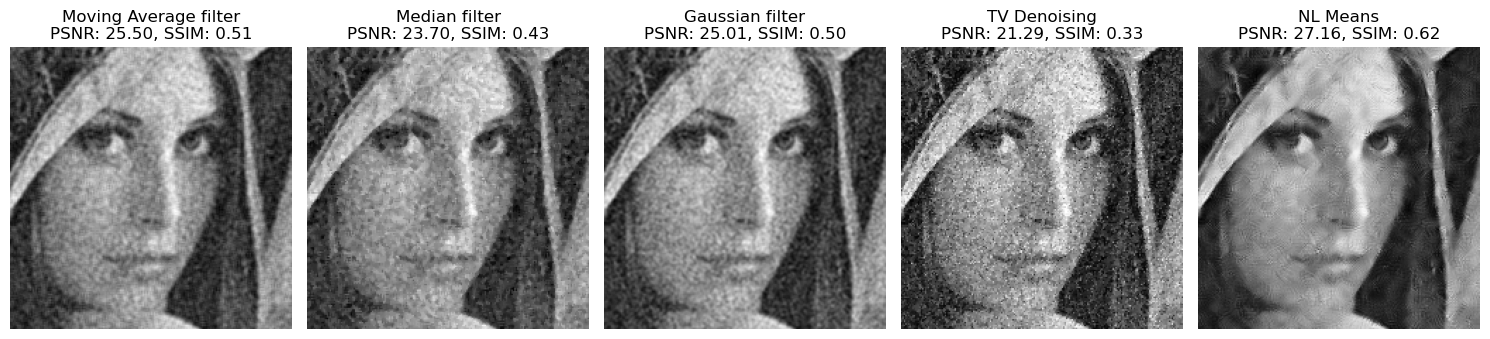

In [49]:
compare("lena512.bmp", sigma=0.15,h=40,a=5,zoom=True)  

+-----------------------+--------------------+---------------------+
|        Method         |        PSNR        |        SSIM         |
+-----------------------+--------------------+---------------------+
| Moving Average filter | 22.964883249049347 | 0.4761257162636608  |
|     Median filter     | 22.22676320000116  | 0.4133235561860022  |
|    Gaussian filter    | 23.01039616234435  | 0.48123328045810115 |
|     TV Denoising      | 21.276686533580424 | 0.3813029665132489  |
|       NL Means        | 25.31598683871686  | 0.6183730621136233  |
+-----------------------+--------------------+---------------------+


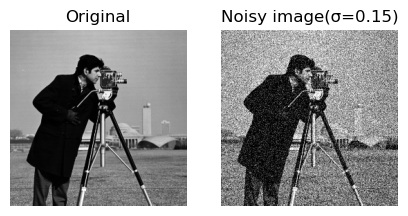

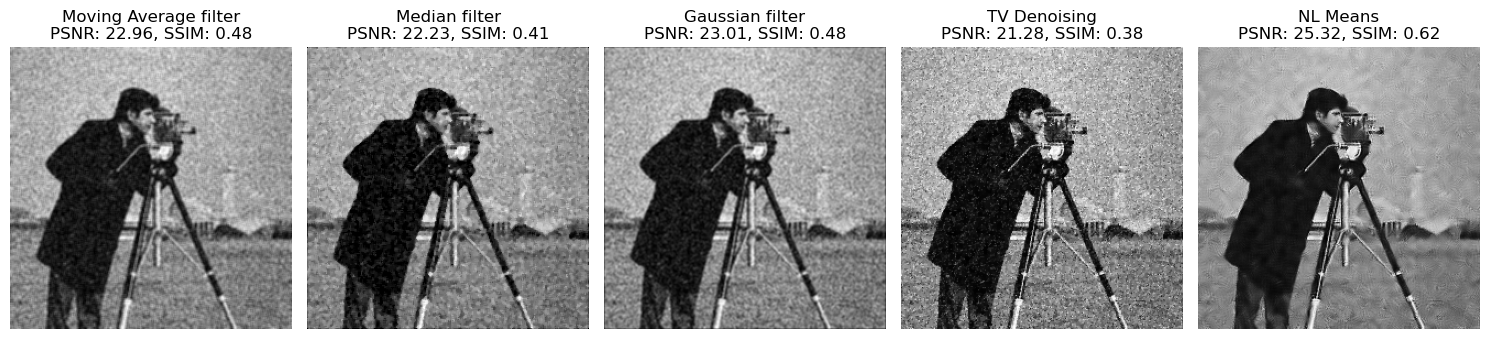

In [53]:
compare("Image3.png", sigma=0.15,h=40,a=5,zoom=False)  

+-----------------------+--------------------+---------------------+
|        Method         |        PSNR        |        SSIM         |
+-----------------------+--------------------+---------------------+
| Moving Average filter | 24.954141167369656 | 0.48132034637435095 |
|     Median filter     | 23.37403189428442  | 0.40827049234202867 |
|    Gaussian filter    | 24.767415659588913 | 0.47062768782454373 |
|     TV Denoising      | 21.40278481598562  | 0.3274165218369014  |
|       NL Means        | 27.16227080546345  | 0.6159706653523982  |
+-----------------------+--------------------+---------------------+


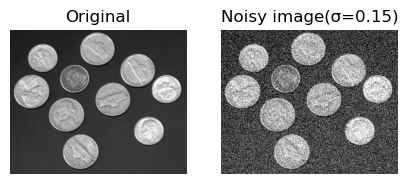

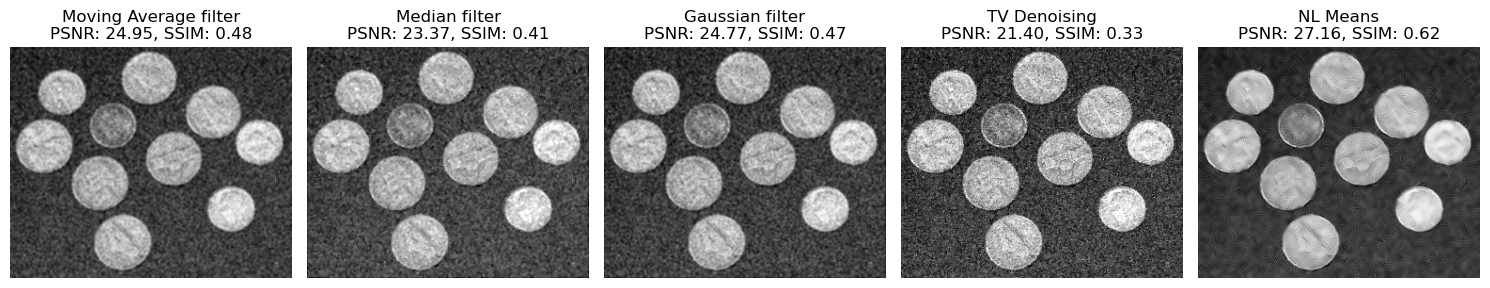

In [54]:
compare("Image4.png", sigma=0.15,h=40,a=5,zoom=False)  

<h2>Showing Limitations</h2>
<h4>Varying parameters give varied PSNRs/SSIMs and time of execution differs as well</h4>

In [19]:
def NL_limitation(image, sigma):
    original_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    original_image = cv2.resize(original_image,(256,256))
    
    noisy_image = gaussian_noise(original_image, sigma=sigma)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
        
    axes[0].imshow(original_image[50:220,50:220], cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Plot the noisy image
    axes[1].imshow(noisy_image[50:220,50:220], cmap='gray')
    axes[1].set_title(f"Noisy image(σ={sigma})")
    axes[1].axis("off")
    
    denoised_NL1 = non_local_means(noisy_image, 15, 5, h=20,a=5) #h=32,a=5
    denoised_NL2 = non_local_means(noisy_image, 10, 5, h=30,a=5) #28, 8
    denoised_NL3 = non_local_means(noisy_image, 21, 7, h=40,a=5) #21, 7,
    denoised_NL4 = non_local_means(noisy_image, 11, 5, h=50,a=5) #25, 8,

    # Calculate PSNR and SSIM for each denoised image
    parameters = ['window_size=15, Ni=5, h=20', 'window_size=10, Ni=5, h=30', 'window_size=21, Ni=7, h=40', 'window_size=11, Ni=5, h=50']
    psnr_values = []
    ssim_values = []

    for denoised_img in [denoised_NL1, denoised_NL2, denoised_NL3, denoised_NL4]:
        psnr = peak_signal_noise_ratio(img_as_ubyte(original_image), img_as_ubyte(denoised_img), data_range=255)
        ssim_val, _ = ssim(img_as_ubyte(original_image), img_as_ubyte(denoised_img), full=True)
        psnr_values.append(psnr)
        ssim_values.append(ssim_val)

    # Plot the denoised images
    fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
    k=0
    for i in range(2):
        for j in range(2):
            axes1[i, j].imshow([denoised_NL1, denoised_NL2, denoised_NL3, denoised_NL4][k][50:220,50:220], cmap='gray')
            axes1[i, j].set_title(f"{parameters[k]}\nPSNR: {psnr_values[k]:.2f}, SSIM: {ssim_values[k]:.2f}")
            axes1[i, j].axis("off")
            k += 1

    plt.tight_layout()
    plt.show()
    

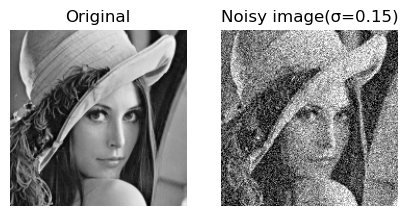

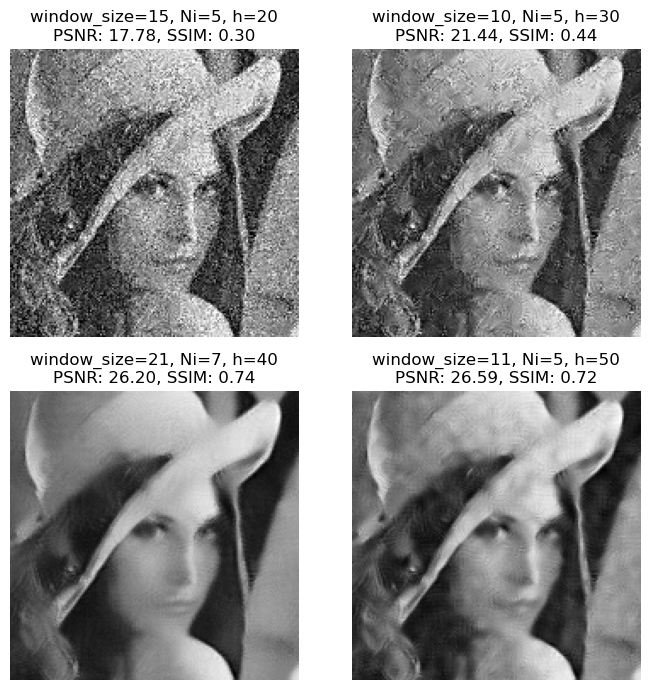

In [20]:
NL_limitation('lena512.bmp',sigma=0.15)